# Watermark Detection


## 1. Setup

In [1]:
import os
import matplotlib.pyplot as plt

import torch
try:
    import torch_xla.core.xla_model as xm
except ImportError:
    xm = None

import numpy as np

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = xm.xla_device()

print('Current device:', device)

Current device: mps


## 2. Visualize Data

In [3]:
from project.data.data_module import DataModule

hparams = {
    'learning_rate': 1e-05,
    'batch_size': 64,
    'batch_norm': False,
    'epochs': 20,
    'num_classes': 2,
    'num_workers': 8,
    'device': device,
    'load_method': 'memory',
}

data_module = DataModule(hparams)

In [9]:
dataiter = iter(data_module.get_train_dataloader())
for images, labels in dataiter:
    break

In [10]:
idx_to_class = data_module.get_idx_to_class_dict()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


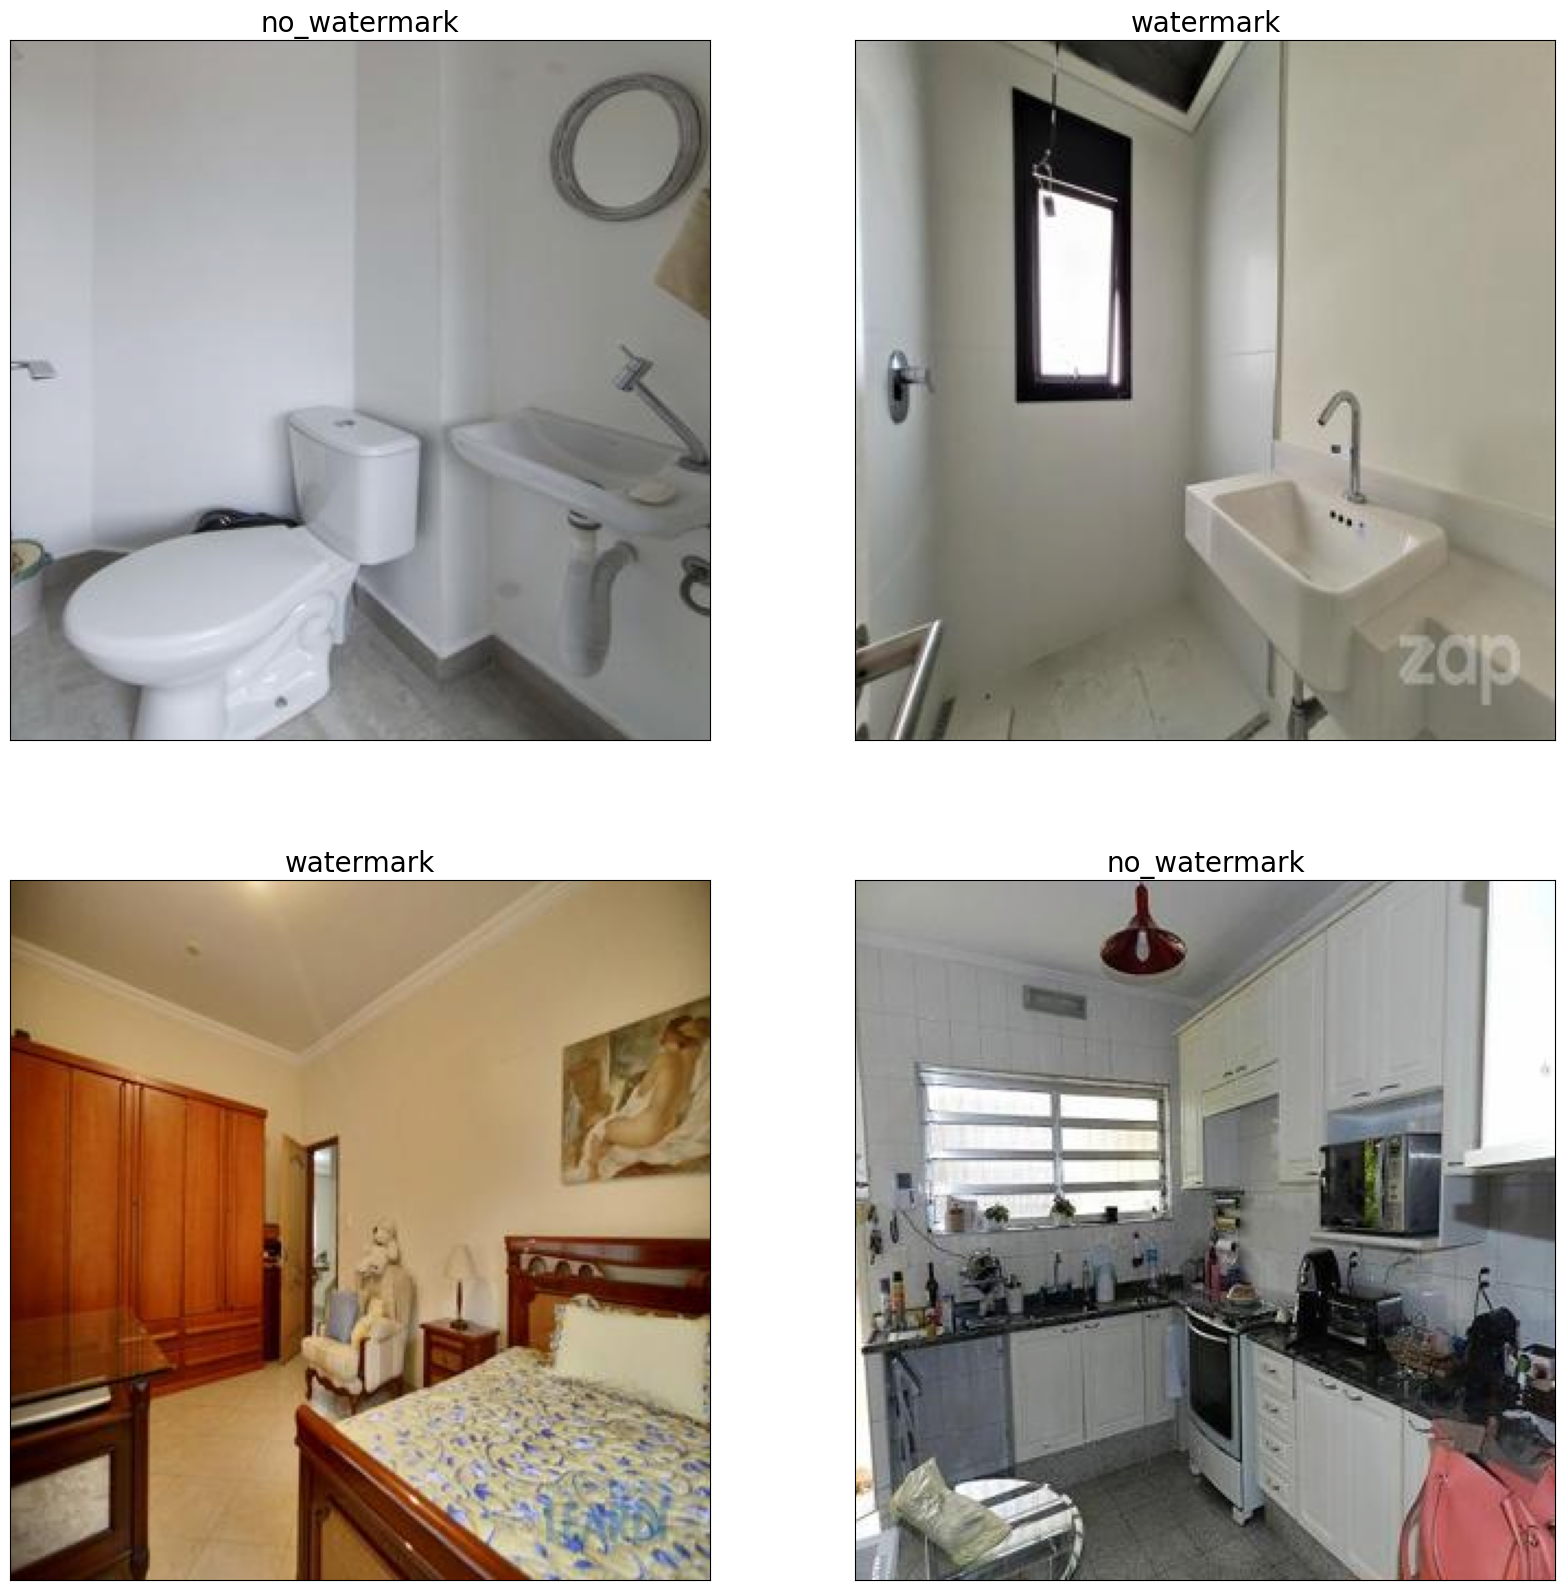

In [11]:
from project.utils.images import imshow

fig = plt.figure(figsize=(20,20))

for idx in range(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    imshow(images[idx], ax)
    ax.set_title(idx_to_class[int(labels[idx])], fontdict={'fontsize': 20})

## 3. Baseline Model

In [12]:
from project.networks.naive import NaiveModel
from project.utils.models import init_weights, number_of_parameters

naive_model = NaiveModel(hparams=hparams).to(device)
naive_model.apply(init_weights)

print('# Parameters: ', number_of_parameters(naive_model))

# Parameters:  4723521


In [13]:
from torch.utils.tensorboard import SummaryWriter
from logs.settings import LOGS_ROOT

logs_path = os.path.join(LOGS_ROOT, naive_model._get_name())

num_of_runs = len(os.listdir(logs_path)) if os.path.exists(logs_path) else 0

logs_path = os.path.join(logs_path, f'run_{num_of_runs + 1}')
logger = SummaryWriter(logs_path)

In [14]:
from project.training import train_model
import torch.nn as nn

loss = nn.BCELoss()

hparams['epochs'] = 1

train_model(naive_model, data_module, loss, logger, hparams)

Validation Epoch [1/1]: 100%|████████████████████████████████████████████████████████████████████| 69/69 [00:11<00:00,  6.27it/s, val_loss=0.69281231]


In [17]:
train_dataloader = data_module.get_train_dataloader()
test_dataloader = data_module.get_test_dataloader()

print(f"Training Acc: {naive_model.get_accuracy(train_dataloader)[1] * 100}%")
print(f"Validation Acc: {naive_model.get_accuracy(test_dataloader)[1] * 100}%")

100%|███████████████████████████████████████| 206/206 [00:32<00:00,  6.41it/s]


Training Acc: 51.06592823002807%


100%|█████████████████████████████████████████| 69/69 [00:12<00:00,  5.66it/s]

Validation Acc: 51.06915377616015%
